# 2.8 Discontinuous Galerkin Methods

* Use discontinuous finite element spaces to solve PDEs. 
* Allows upwind-stabilization for convection-dominated problems
* Requires additional jump terms for consistency 

Interior penalty DG form for $-\Delta u$:

$$
\DeclareMathOperator{\Div}{div}
A(u,v) = \sum_T \int_T \nabla u \nabla v
-  \sum_F \int_F \{ n \nabla u \} [v] 
-  \sum_F \int_F \{ n \nabla v \} [u] 
+ \frac{\alpha p^2}{h} \sum_F \int_F [u][v]
$$

with jump-term over facets:
$$
[u] = u_{left} - u_{right}
$$

and averaging operator
$$
\{ n \nabla u \} = \tfrac{1}{2} (n_{left} \nabla u_{left} + n_{left} \nabla u_{right})
$$

DG form for $\Div (b u)$, where $b$ is the given wind:

$$
B(u,v) = -\sum_T b u \nabla v + \sum_F \int_F b\cdot n   u^{upwind} v 
$$

In [4]:
from ngsolve import *
from ngsolve.webgui import Draw
mesh = Mesh(unit_square.GenerateMesh(maxh=0.3))
print(mesh)

The space is responsible for allocating the matrix graph. Tell it that it should reserve entries for the coupling terms:

In [ ]:
order=4
fes = L2(mesh, order=order, dgjumps=True)
u,v = fes.TnT()

print(u)
print(u.Other())

coef trial-function diffop = Id, real

coef trial-function diffop = Id, real



Every facet has a master element. The value from the other element is referred to via the
`Other()` operator:

In [7]:
jump_u = u-u.Other()
jump_v = v-v.Other()
n = specialcf.normal(2)
mean_dudn = 0.5*n * (grad(u)+grad(u.Other()))
mean_dvdn = 0.5*n * (grad(v)+grad(v.Other()))

print(n)
print(mean_dudn)

coef normal vector, real, dim=2

coef innerproduct, fix size = 2, real
  coef scale 0.5, real, dim=2
    coef normal vector, real, dim=2
  coef binary operation '+', real, dim=2
    coef trial-function diffop = grad, real, dim=2
    coef trial-function diffop = grad, real, dim=2



Integrals on facets are computed by setting `skeleton=True`. 
* `dx(skeleton=True)` iterates over all internal faces
* `ds(skeleton=True)` iterates over all boundary faces

In [10]:
alpha = 4
h = specialcf.mesh_size
diffusion = grad(u)*grad(v) * dx \
    +alpha*order**2/h*jump_u*jump_v * dx(skeleton=True) \
    +(-mean_dudn*jump_v-mean_dvdn*jump_u) * dx(skeleton=True) \
    +alpha*order**2/h*u*v * ds(skeleton=True) \
    +(-n*grad(u)*v-n*grad(v)*u)* ds(skeleton=True)

a = BilinearForm(diffusion).Assemble()

print(h)
print(diffusion)
print(a)

coef class `void __cdecl ExportCoefficientFunction(class pybind11::module_ & __ptr64)'::`2'::MeshSizeCF, real

coef innerproduct, fix size = 2, real
  coef trial-function diffop = grad, real, dim=2
  coef test-function diffop = grad, real, dim=2
 VOL
coef binary operation '*', real
  coef binary operation '*', real
    coef binary operation '/', real
      coef 64, real
      coef class `void __cdecl ExportCoefficientFunction(class pybind11::module_ & __ptr64)'::`2'::MeshSizeCF, real
    coef binary operation '-', real
      coef trial-function diffop = Id, real
      coef trial-function diffop = Id, real
  coef binary operation '-', real
    coef test-function diffop = Id, real
    coef test-function diffop = Id, real
 VOL
coef binary operation '-', real
  coef binary operation '*', real
    coef scale -1, real
      coef innerproduct, fix size = 2, real
        coef scale 0.5, real, dim=2
          coef normal vector, real, dim=2
        coef binary operation '+', real, dim=2
       

In [11]:
f = LinearForm(1*v*dx).Assemble()

In [13]:
gfu = GridFunction(fes, name="uDG")
gfu.vec.data = a.mat.Inverse() * f.vec
Draw (gfu)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

DG requires a lot of additional matrix entries:

In [14]:
fes2 = L2(mesh, order=order)
ul2,vl2 = fes2.TnT()
a2 = BilinearForm(ul2*vl2*dx).Assemble()
print ("DG-matrix nze:", a.mat.nze)
print ("L2-matrix nze:", a2.mat.nze)

DG-matrix nze: 18900
L2-matrix nze: 5400


Next we are solving a convection-diffusion problem:

In [15]:
alpha = 4
h = specialcf.mesh_size

The `IfPos` checks whether the first argument is positive. Then it returns the second one, else the third one. This is used to define the upwind flux. The check is performed in every integration-point on the skeleton:

In [16]:
b = CF( (20,5) )
uup = IfPos(b*n, u, u.Other())

convection = -b * u * grad(v)*dx + b*n*uup*jump_v * dx(skeleton=True)

acd = BilinearForm(diffusion + convection).Assemble()

In [17]:
gfu = GridFunction(fes)
gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec
Draw (gfu)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## Hybrid Discontinuous Galerkin methods
use additionally the *hybrid* facet variable on the skeleton:

$$
\DeclareMathOperator{\Div}{div}
A(u,\widehat u; v, \widehat v) = 
  \sum_T \int_T \nabla u \nabla v
- \sum_T \int_{\partial T} n \nabla u (v-\widehat v)
- \sum_T \int_{\partial T} n \nabla v (u-\widehat u)
+ \frac{\alpha p^2}{h} \sum_F \int_F (u-\widehat u)(v-\widehat v)
$$

the jump-term is now replaced by the difference $u - \widehat u$.

No additional matrix entries across elements are produced. Dirichlet boundary conditions are set as usual to the facet variable:

In [18]:
order=4
V = L2(mesh, order=order)
F = FacetFESpace(mesh, order=order, dirichlet="bottom|left|right|top")
fes = V*F
u,uhat = fes.TrialFunction()
v,vhat = fes.TestFunction()

Now, the jump is the difference between element-term and facet-term:

In [19]:
jump_u = u-uhat
jump_v = v-vhat

In [20]:
alpha = 4
condense = True
h = specialcf.mesh_size
n = specialcf.normal(mesh.dim)

a = BilinearForm(fes, condense=condense)
dS = dx(element_boundary=True)
a += grad(u)*grad(v)*dx + \
    alpha*order**2/h*jump_u*jump_v*dS + \
    (-grad(u)*n*jump_v - grad(v)*n*jump_u)*dS

b = CF( (20,1) )
uup = IfPos(b*n, u, uhat)
a += -b * u * grad(v)*dx + b*n*uup*jump_v *dS
a.Assemble()

f = LinearForm(1*v*dx).Assemble()

gfu = GridFunction(fes)

print ("A non-zero elements:", a.mat.nze)

A non-zero elements: 4650


In [21]:
if not condense:
    inv = a.mat.Inverse(fes.FreeDofs(), "umfpack")
    gfu.vec.data = inv * f.vec
else:
    fmod = (f.vec + a.harmonic_extension_trans * f.vec).Evaluate()
    
    inv = a.mat.Inverse(fes.FreeDofs(True))
    gfu.vec.data = inv * fmod
    
    gfu.vec.data += a.harmonic_extension * gfu.vec
    gfu.vec.data += a.inner_solve * f.vec

Draw (gfu.components[0], mesh, "u-HDG");

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

## Projected Jumps
The polynomial order of the facet-space can be reduced by one by inserting an $L_2$-projection into the penalty term. This can be implemented by keeping the highest order basis functions of the facet space discontinuous, see [Lehrenfeld-Schöberl: High order exactly divergence-free Hybrid Discontinuous Galerkin Methods for unsteady incompressible flows](https://www.sciencedirect.com/science/article/pii/S004578251630264X?via%3Dihub):

$$
\DeclareMathOperator{\Div}{div}
A(u,\widehat u; v, \widehat v) = 
  \sum_T \int_T \nabla u \nabla v
- \sum_T \int_{\partial T} n \nabla u (v-\widehat v)
- \sum_T \int_{\partial T} n \nabla v (u-\widehat u)
+ \frac{\alpha p^2}{h} \sum_F \int_F (\Pi u-\widehat u)(\Pi v-\widehat v)
$$

This is achieved by setting the flag `highest_order_dc=True` in the `FacetFESpace`. 
The number of matrix entries is reduced, while the order of convergence is preserved.
This trick does not work in the case of significant convection.

In [22]:
order=4
V = L2(mesh, order=order)
F = FacetFESpace(mesh, order=order, dirichlet="bottom|left|right|top", \
                          highest_order_dc=True)
fes = V*F
u,uhat = fes.TrialFunction()
v,vhat = fes.TestFunction()

jump_u = u-uhat
jump_v = v-vhat

alpha = 2
h = specialcf.mesh_size
n = specialcf.normal(mesh.dim)

a = BilinearForm(fes, condense=True)
dS = dx(element_boundary=True)
a += grad(u)*grad(v)*dx + \
    alpha*(order+1)**2/h*jump_u*jump_v*dS + \
    (-grad(u)*n*jump_v - grad(v)*n*jump_u)*dS
a.Assemble()

f = LinearForm(fes)
f += 1*v*dx
f.Assemble()

gfu = GridFunction(fes)

f.vec.data += a.harmonic_extension_trans * f.vec 
    
inv = a.mat.Inverse(fes.FreeDofs(True), "sparsecholesky")
gfu.vec.data = inv * f.vec
    
gfu.vec.data += a.harmonic_extension * gfu.vec
gfu.vec.data += a.inner_solve * f.vec

Draw (gfu.components[0], mesh, "u-HDG")

print ("A non-zero elements:", a.mat.nze)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

A non-zero elements: 2976


### Remarks on sparsity pattern in NGSolve

#### Remark 1: The sparsity pattern is set up a-priorily
* The sparsity pattern of a sparse matrix in NGSolve is independent of its entries (it's set up a-priorily). 
* We can have "nonzero" entries that have the value 0

Below we show the reserved memory for the sparse matrix and the (numerically) non-zero entries in this sparse matrix. 

In [23]:
fes2 = L2(mesh, order=order, dgjumps=True)
u,v=fes2.TnT()
a3 = BilinearForm(fes2)
a3 += u*v*dx + (u+u.Other())*v*dx(skeleton=True)
a3.Assemble();

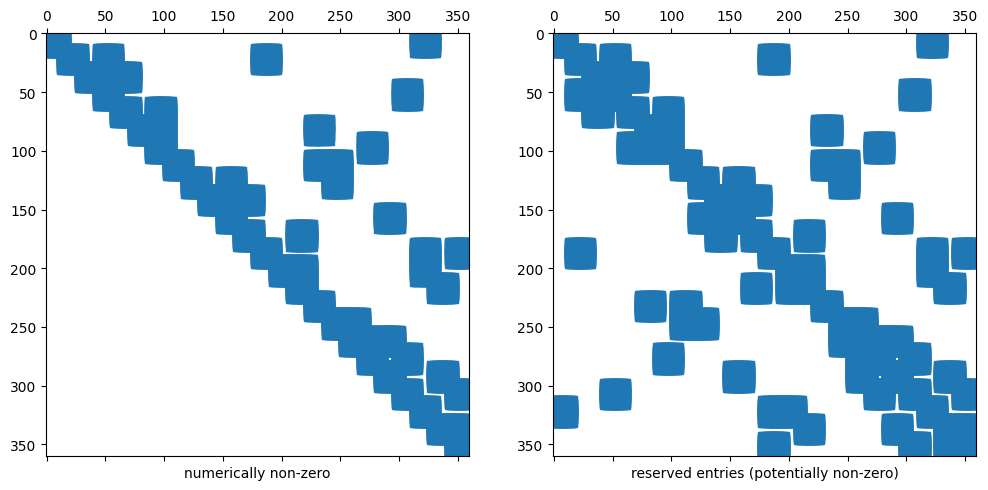

In [24]:
import scipy.sparse as sp
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (12, 12)
A = sp.csr_matrix(a3.mat.CSR())
fig = plt.figure(); ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.set_xlabel("numerically non-zero"); ax1.spy(A)
ax2.set_xlabel("reserved entries (potentially non-zero)"); ax2.spy(A,precision=-1)
plt.show()

#### Remark 2: Sparsity pattern with and without `dgjumps=True` is different

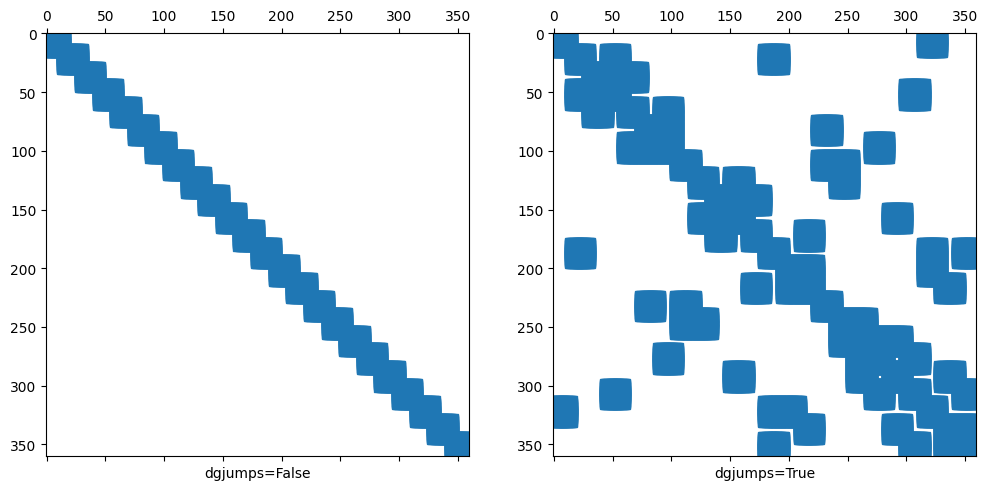

In [25]:
a1 = BilinearForm(L2(mesh, order=order, dgjumps=False)); a1.Assemble()
a2 = BilinearForm(L2(mesh, order=order, dgjumps=True)); a2.Assemble()
A1 = sp.csr_matrix(a1.mat.CSR())
A2 = sp.csr_matrix(a2.mat.CSR())
fig = plt.figure(); ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.set_xlabel("dgjumps=False"); ax1.spy(A1,precision=-1)
ax2.set_xlabel("dgjumps=True"); ax2.spy(A2,precision=-1)
plt.show()

#### Remark 3: Dof numbering of higher order FESpaces 

* In `NGSolve` `FESpace`s typically have a numbering where the first block of dofs corresponds to a low order subspace (which is convenient for iterative solvers). 
* For L2 this means that the first dofs correspond to the constants on elements. 

* You can turn this behavior off for some spaces, e.g. for L2 by adding the flag `all_dofs_together`.

We demonstrate this in the next comparison:

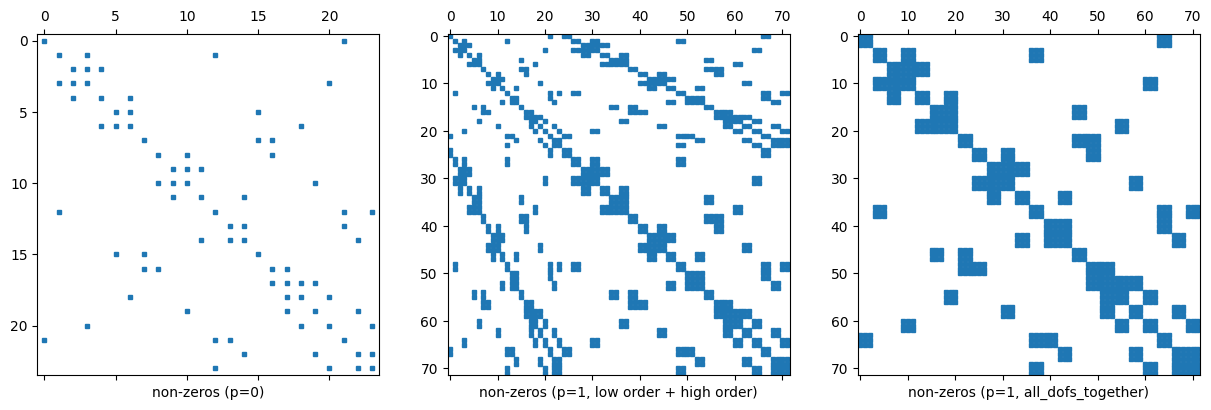

In [26]:
plt.rcParams['figure.figsize'] = (15, 15)
fig = plt.figure()
ax = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]

for i, (order, all_dofs_together, label) in enumerate([(0,False, "non-zeros (p=0)"),
                                                    (1,False,"non-zeros (p=1, low order + high order)"),
                                                    (1,True,"non-zeros (p=1, all_dofs_together)")]):
    a = BilinearForm(L2(mesh,order=order,dgjumps=True,all_dofs_together=all_dofs_together))
    a.Assemble()
    ax[i].spy(sp.csr_matrix(a.mat.CSR()),markersize=3,precision=-1)
    ax[i].set_xlabel(label)